In [534]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import (
    SelectFromModel, 
    SelectKBest, 
    mutual_info_classif,
    chi2,
    f_classif
)

from sklearn.preprocessing import MinMaxScaler
from category_encoders.binary import BinaryEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.pipeline import make_pipeline


In [415]:
df = pd.read_csv('data/train.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [416]:
df_train.head(5)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
674554,False,False,State Police,11/16/2014 11:59:00 AM,ESSEX,V,277048371,True,N,Other/Error,36.0,N,W,M,False
1255314,False,False,CSP Troop C,06/13/2016 10:53:46 PM,TOLLAND,V,1000003506,False,N,STC Violation,50.0,N,W,F,False
1594148,False,False,Norwalk,02/12/2017 02:08:00 AM,NORWALK,V,100000075,True,N,Traffic Control Signal,29.0,H,W,F,True
724674,False,False,State Police,12/20/2014 07:36:00 AM,FARMINGTON,V,1000003200,True,N,Other/Error,33.0,N,W,F,False
384484,False,False,Newtown,06/04/2014 11:15:00 PM,Newtown,V,336,True,N,Speed Related,19.0,N,W,F,True


In [417]:
df_train.shape

(1978914, 15)

The train dataset has almost 2 M rows and 15 features, one of them id the target column we want to predict - ContrabandIndicator

In [418]:
print('Percentage of duplicated rows:', round(df_train[df_train.duplicated()].shape[0]/df_train.shape[0]*100,2),'%')

Percentage of duplicated rows: 6.61 %


In [419]:
def drop_duplicates(data):
    
    data_ = data.copy()
    data_.drop_duplicates(inplace=True)
    
    return data_

In [420]:
df_train = drop_duplicates(df_train)

In [421]:
pd.DataFrame((df_train.isnull().sum()/df_train.shape[0]*100).sort_values(ascending=False))

,0
StatuteReason,0.021536
InterventionLocationName,0.001353
SearchAuthorizationCode,0.000433
ReportingOfficerIdentificationID,0.000108
InterventionReasonCode,0.000054
TownResidentIndicator,0.000000
SubjectSexCode,0.000000
SubjectRaceCode,0.000000
SubjectEthnicityCode,0.000000
SubjectAge,0.000000


As there are only a few number of missing values in each feature, the corresponding rows will be dropped from the dataset. The maximum percentage of missing values in a feature is 0.022% (StatuteReason) so dropping a few rows will not have a great impact in process. 

In [422]:
def drop_nulls(data):
    
    data_ = data.copy()
    data_.dropna(inplace=True)
    
    return data_
    

In [423]:
df_train = drop_nulls(df_train)

In [424]:
pd.DataFrame(df_train.nunique().sort_values(ascending=False), columns=['# Unique values'])

,# Unique values
InterventionDateTime,1255084
ReportingOfficerIdentificationID,8401
InterventionLocationName,2259
Department Name,122
SubjectAge,99
StatuteReason,18
SubjectRaceCode,4
SearchAuthorizationCode,4
InterventionReasonCode,4
SubjectEthnicityCode,3


InterventionDateTime is the feature with the highest number of unique values, expectable given all the possibilities of combination of date and time thourghout the 4 years this data has been colected.
Following , ReportingOfficerIdentificationID is the second with the highest number of unique values and InterventionLocationName the third.
ReportingOfficerIdentificationID will most likely be dropped, as the contrabandfound shouldn't be reliable of the officer doing the searches. InterventionLocationName could also be dropped as may be there some bias introduced by locations where some minorities live.

In [425]:
pd.DataFrame(df_train.dtypes.sort_values(), columns=['Data Type'])

,Data Type
VehicleSearchedIndicator,bool
ContrabandIndicator,bool
ResidentIndicator,bool
TownResidentIndicator,bool
SubjectAge,float64
Department Name,object
InterventionDateTime,object
InterventionLocationName,object
InterventionReasonCode,object
ReportingOfficerIdentificationID,object


In the dataset there are 4 boolean features, 1 float feature and the restant are all string objects.

In [426]:
pd.concat([pd.DataFrame(df_train.VehicleSearchedIndicator.value_counts()/df_train.shape[0]*100), 
           pd.DataFrame(df_train.ContrabandIndicator.value_counts()/df_train.shape[0]*100)], axis=1)

,VehicleSearchedIndicator,ContrabandIndicator
False,96.92042,98.86519
True,3.07958,1.13481


In the whole dataset, we have 3.1% of cars searched but only 1.1% of the cars did have contraband (this accounts for cars searched and not searched)

In [427]:
df_train[df_train.VehicleSearchedIndicator == True]['ContrabandIndicator'].value_counts()/df_train[df_train.VehicleSearchedIndicator == True].shape[0]*100

False    66.941423
True     33.058577
Name: ContrabandIndicator, dtype: float64

From all the Searched vehicles, in 67% of them, it wasn't found any contraband - 33% precision. Let's have a look on the percentages of the true and false positive rates for each of the protected classes we will care not to have discrepancies in the precision among them.

In [428]:
df_vehicle_searched =  pd.DataFrame(df_train[df_train.VehicleSearchedIndicator == True])


In [429]:
def plot_contraband_protectedclasses(data, protected_class_column):
    
    df_vehicle_searched =  pd.DataFrame(data[data.VehicleSearchedIndicator == True])
    
    ab = df_vehicle_searched.groupby([protected_class_column, 'ContrabandIndicator']).agg({'ContrabandIndicator':'count'})
    ab.columns = ['ContrabandIndicator_Percentage']
    ab.reset_index(inplace=True) 
    ab = ab.groupby([protected_class_column, 'ContrabandIndicator']).agg({'ContrabandIndicator_Percentage': 'sum'}).groupby(level=0).apply(lambda x:
                                                 round(100 * x / float(x.sum()),1))
    
    return ab

In [430]:
plot_contraband_protectedclasses(df_train, 'SubjectEthnicityCode')

ContrabandIndicator_Percentage
SubjectEthnicityCode ContrabandIndicator                                
H                    False                                          72.6
                     True                                           27.4
M                    False                                          72.9
                     True                                           27.1
N                    False                                          65.2
                     True                                           34.8

In [431]:
plot_contraband_protectedclasses(df_train, 'SubjectRaceCode')

ContrabandIndicator_Percentage
SubjectRaceCode ContrabandIndicator                                
A               False                                          71.1
                True                                           28.9
B               False                                          70.5
                True                                           29.5
I               False                                          69.4
                True                                           30.6
W               False                                          65.4
                True                                           34.6

In [432]:
plot_contraband_protectedclasses(df_train, 'SubjectSexCode')

ContrabandIndicator_Percentage
SubjectSexCode ContrabandIndicator                                
F              False                                          68.4
               True                                           31.6
M              False                                          66.6
               True                                           33.4

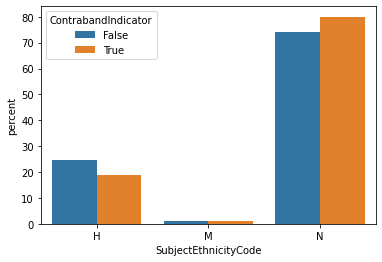

In [433]:
counts = (df[df.VehicleSearchedIndicator == True].groupby(['ContrabandIndicator'])['SubjectEthnicityCode']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('SubjectEthnicityCode'))
sns.barplot(x="SubjectEthnicityCode", y="percent", hue="ContrabandIndicator", data=counts);


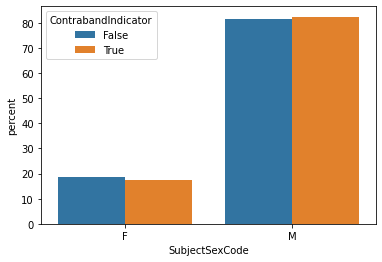

In [434]:
counts = (df[df.VehicleSearchedIndicator == True].groupby(['ContrabandIndicator'])['SubjectSexCode']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('SubjectSexCode'))
sns.barplot(x="SubjectSexCode", y="percent", hue="ContrabandIndicator", data=counts);


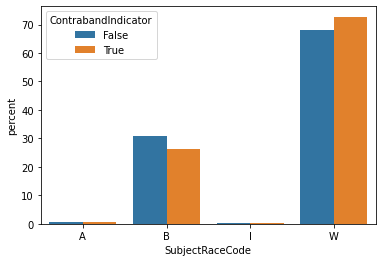

In [435]:
counts = (df[df.VehicleSearchedIndicator == True].groupby(['ContrabandIndicator'])['SubjectRaceCode']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('SubjectRaceCode'))
sns.barplot(x="SubjectRaceCode", y="percent", hue="ContrabandIndicator", data=counts);

In [436]:
cardinality = df_train.describe(exclude=np.number).T

In [437]:
cardinality

,count,unique,top,freq
VehicleSearchedIndicator,1847622,2,False,1790723
ContrabandIndicator,1847622,2,False,1826655
Department Name,1847622,122,State Police,256516
InterventionDateTime,1847622,1255084,03/07/2014 12:00:00 AM,220
InterventionLocationName,1847622,2259,NEW HAVEN,60021
InterventionReasonCode,1847622,4,V,1629004
ReportingOfficerIdentificationID,1847622,8401,WCW0264,6632
ResidentIndicator,1847622,2,True,1591818
SearchAuthorizationCode,1847622,4,N,1781028
StatuteReason,1847622,18,Speed Related,508925


### 2. Boolean Features

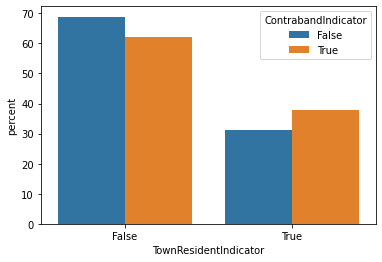

In [438]:
counts = (df.groupby(['ContrabandIndicator'])['TownResidentIndicator']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('TownResidentIndicator'))
sns.barplot(x="TownResidentIndicator", y="percent", hue="ContrabandIndicator", data=counts);


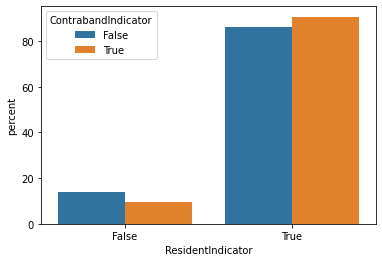

In [439]:
counts = (df.groupby(['ContrabandIndicator'])['ResidentIndicator']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('ResidentIndicator'))
sns.barplot(x="ResidentIndicator", y="percent", hue="ContrabandIndicator", data=counts);

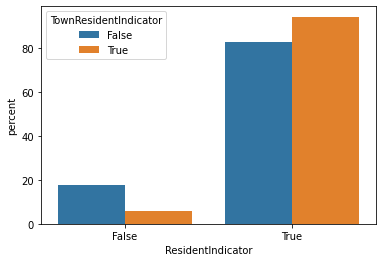

In [440]:
counts = (df.groupby(['TownResidentIndicator'])['ResidentIndicator']
                     .value_counts(normalize=True)
                     .rename('percent')
                     .mul(100)
                     .reset_index()
                     .sort_values('ResidentIndicator'))
sns.barplot(x="ResidentIndicator", y="percent", hue="TownResidentIndicator", data=counts);

### 3. Object Features

In [441]:
df_train['Department Name'].nunique()

122

The department names are lowered and white spaces are removed from the end and beginign of the string to uniformize all the string.

In [442]:
df_train['Department Name'] = df_train['Department Name'].str.lower().str.strip()

In [443]:
df_train['Department Name'].nunique()

122

In [444]:
pd.DataFrame(df_train['Department Name'].value_counts()/df_train.shape[0]*100)#.sort_values(ascending=False)

,Department Name
state police,13.883576
new haven,2.846524
csp troop c,2.374241
csp troop f,2.148762
csp troop a,2.040569
...,...
mta,0.003247
mashantucket pequot,0.001732
met dist water authority,0.000325
mohegan tribal,0.000271


State police department is the deparment which has the most entries in the dataset, followed by New Haven and CSP Troops departments.

In [445]:
df_train.InterventionLocationName.nunique()

2259

In [446]:
df_train.InterventionLocationName.value_counts()

NEW HAVEN               60021
WALLINGFORD             33607
Manchester              27589
WESTPORT                24931
Hartford                24784
                        ...  
Nathaniel St/East Ma        1
East Main at Columbu        1
East Main St. at Wal        1
Amherst St/Oliver St        1
cedar lane                  1
Name: InterventionLocationName, Length: 2259, dtype: int64

In [447]:
def preprocess_interventionlocation(data):
    
    data_ = data.copy()
    
    data_.InterventionLocationName = data_.InterventionLocationName.str.lower().str.strip()
    data_.InterventionLocationName = data_.InterventionLocationName.str.replace('street', 'st')
    data_.InterventionLocationName = data_.InterventionLocationName.str.replace('road', 'rd')
    data_.InterventionLocationName = data_.InterventionLocationName.str.replace('  ', '')
    
    return data_

In [448]:
df_train = preprocess_interventionlocation(df_train)

In [449]:
df_train.InterventionLocationName.nunique()

1337

For the InterventionLocation feature, uniformizing the strings allowed a reduction of 41% of the variability of the names in the dataset (reduced from 2259 to 1337 unique strings).

In [450]:
pd.DataFrame(df_train.InterventionLocationName.value_counts()/df_train.shape[0]*100).head(100)

,InterventionLocationName
new haven,3.640193
stamford,2.101566
hartford,2.036943
wallingford,1.948721
danbury,1.911322
...,...
thomaston,0.318247
stonington,0.315865
harwinton,0.310074
north stonington,0.309154


In [451]:
df_train.StatuteReason.nunique()

18

In [452]:
df_train.StatuteReason.value_counts()

Speed Related             508925
Defective Lights          169846
Registration              169664
Cell Phone                163860
Moving Violation          143463
Other                     133215
Traffic Control Signal    132667
Stop Sign                 123016
STC Violation              92485
Seatbelt                   62402
Display of Plates          50959
Other/Error                34943
Window Tint                20680
Administrative Offense     20328
Suspended License           9244
Unlicensed Operation        6912
Equipment Violation         4991
Stop Sign                     22
Name: StatuteReason, dtype: int64

In [453]:
df_train.StatuteReason = df_train.StatuteReason.str.lower().str.strip()

In [454]:
df_train.StatuteReason.nunique()

17

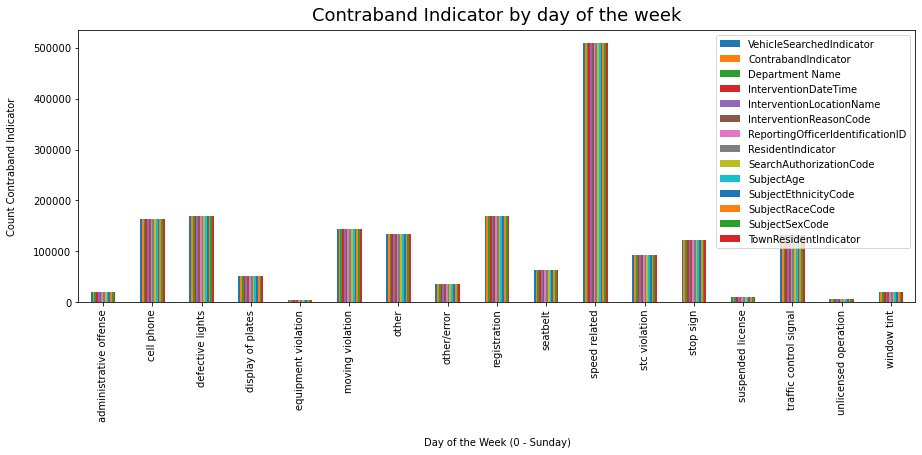

In [455]:
df_train.groupby(['StatuteReason']).count().plot(kind='bar', figsize=(15, 5),)
plt.title("Contraband Indicator by day of the week", y=1.013, fontsize=18)
plt.xlabel("Day of the Week (0 - Sunday)", labelpad=16)
plt.ylabel("Count Contraband Indicator", labelpad=16);

Changing format of feature InterventionDateTime to datetime type in order to do further date and time analysis and create other temporal features such as time of the day, month, period of the day, etc.

In [456]:
def preprocess_datetime(data):
    
    data_ = data.copy()
    
    data_.InterventionDateTime = pd.to_datetime(data_.InterventionDateTime, format='%m/%d/%Y %I:%M:%S %p')
    
    
    data_ = data_.assign(HourDay =data_.InterventionDateTime.dt.hour + (data_.InterventionDateTime.dt.minute / 60),
                           DayWeek =data_.InterventionDateTime.dt.dayofweek,
                           Month = data_.InterventionDateTime.dt.month)

    data_['PeriodDay'] = data_['HourDay'].map(lambda x: 'morning' if 5<= x < 13 else('afternoon' if 13 <=x < 18 else 'night'))

    data_.HourDay = data_.HourDay.apply(lambda x: round(x,1)).apply(lambda x: 0.0 if  x==24.0 else x)


    data_.drop(columns=['InterventionDateTime'], inplace=True)
    
    return data_

In [457]:
df_train = preprocess_datetime(df_train)

In [458]:
df_train

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,HourDay,DayWeek,Month,PeriodDay
674554,False,False,state police,essex,V,277048371,True,N,other/error,36.0,N,W,M,False,12.0,6,11,morning
1255314,False,False,csp troop c,tolland,V,1000003506,False,N,stc violation,50.0,N,W,F,False,22.9,0,6,night
1594148,False,False,norwalk,norwalk,V,100000075,True,N,traffic control signal,29.0,H,W,F,True,2.1,6,2,night
724674,False,False,state police,farmington,V,1000003200,True,N,other/error,33.0,N,W,F,False,7.6,5,12,morning
384484,False,False,newtown,newtown,V,336,True,N,speed related,19.0,N,W,F,True,23.2,2,6,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,False,False,old saybrook,old saybrook,V,S17,True,N,registration,29.0,N,W,F,True,17.9,3,11,afternoon
836489,False,False,stratford,stratford,V,30225,True,N,registration,71.0,N,W,M,False,23.1,3,3,night
491263,False,False,orange,orange,V,WKE0770,True,N,speed related,21.0,N,W,F,False,17.3,1,8,afternoon
491755,False,False,newtown,newtown,V,332,True,N,speed related,34.0,N,W,M,True,22.4,1,8,night


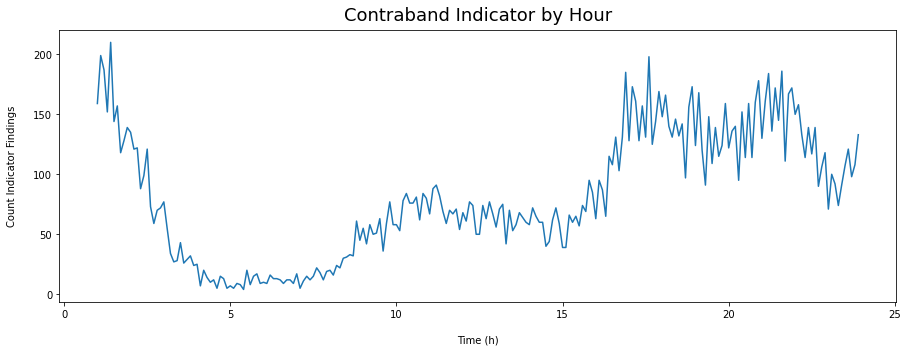

In [464]:
df_train.groupby('HourDay')['ContrabandIndicator'].sum()[1:].plot(kind='line', figsize=(15, 5),)
plt.title("Contraband Indicator by Hour", y=1.013, fontsize=18)
plt.xlabel("Time (h)", labelpad=16)
plt.ylabel("Count Indicator Findings", labelpad=16);   

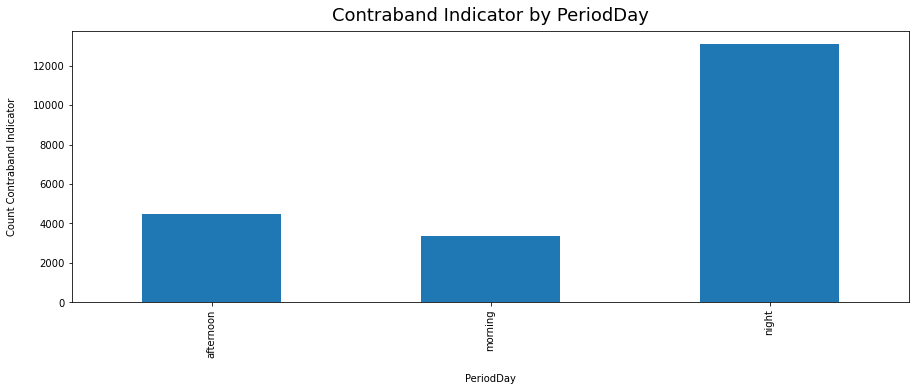

In [461]:
df_train.groupby('PeriodDay')['ContrabandIndicator'].sum().plot(kind='bar', figsize=(15, 5),)
plt.title("Contraband Indicator by PeriodDay", y=1.013, fontsize=18)
plt.xlabel("PeriodDay", labelpad=16)
plt.ylabel("Count Contraband Indicator", labelpad=16);   

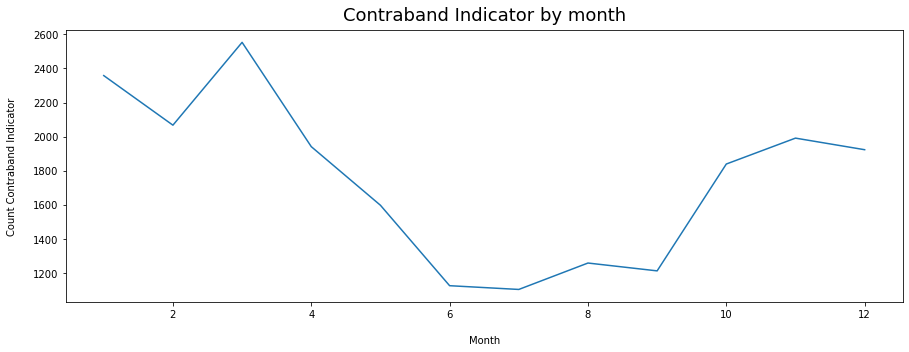

In [462]:
df_train.groupby('Month')['ContrabandIndicator'].sum().plot(kind='line', figsize=(15, 5),)
plt.title("Contraband Indicator by month", y=1.013, fontsize=18)
plt.xlabel("Month", labelpad=16)
plt.ylabel("Count Contraband Indicator", labelpad=16);   

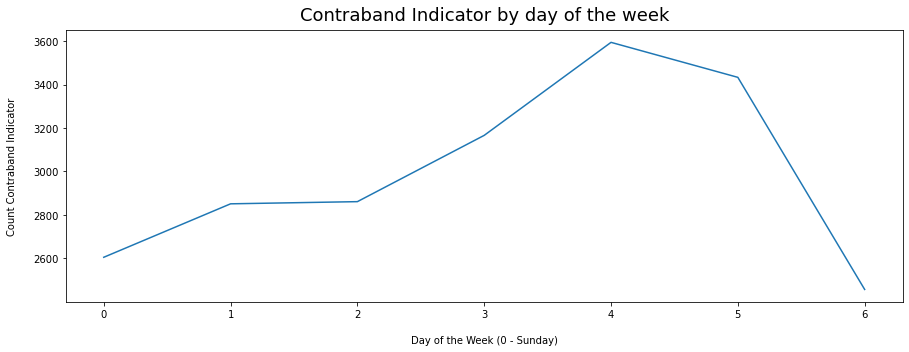

In [466]:
df_train.groupby('DayWeek')['ContrabandIndicator'].sum().plot(kind='line', figsize=(15, 5),)
plt.title("Contraband Indicator by day of the week", y=1.013, fontsize=18)
plt.xlabel("Day of the Week (0 - Sunday)", labelpad=16)
plt.ylabel("Count Contraband Indicator", labelpad=16);   

### 4. Categorical Features

In [483]:
df_train.InterventionReasonCode.unique()

array(['V', 'E', 'I', 'no'], dtype=object)

In [484]:
df_train[(df_train.InterventionReasonCode == 'no')]

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,HourDay,DayWeek,Month,PeriodDay
485944,False,False,stamford,stamford,no,7901,False,N,speed related,23.0,N,W,F,False,14.2,5,8,afternoon
485884,False,False,stamford,stamford,no,7901,True,N,speed related,20.0,N,W,M,True,13.2,5,8,afternoon


There are 2 entries with 'no' in the InterventionReasonCode. These will be dropped not only because they are not a valid InterventionReasonCode but also because it's a very small part of the dataset

In [485]:
df_train.drop(df_train[(df_train.InterventionReasonCode == 'no')].index, inplace=True)

In [486]:
df_train.SearchAuthorizationCode.value_counts()

N    1781026
O      34279
C      20501
I      11814
Name: SearchAuthorizationCode, dtype: int64

In [487]:
df_train.SubjectEthnicityCode.unique()

array(['N', 'H', 'M'], dtype=object)

In [488]:
df_train.SubjectRaceCode.unique()

array(['W', 'B', 'A', 'I'], dtype=object)

In [489]:
df_train.SubjectRaceCode.unique()

array(['W', 'B', 'A', 'I'], dtype=object)

### 5. Float Features

In [490]:
print('Min age:',df_train.SubjectAge.min())
print('Max age:',df_train.SubjectAge.max())
print('Mean age:',round(df_train.SubjectAge.mean(),2))
print('Std age:',round(df_train.SubjectAge.std(),2))
print('Median age:',df_train.SubjectAge.median())

Min age: 1.0
Max age: 99.0
Mean age: 38.66
Std age: 14.96
Median age: 36.0


In [491]:
(df_train.SubjectAge<12).sum()

563

There are a few rows where the age of the driver is low. Being a data entry issue, we will replace all the ages lower than 12 with 12, considering this would be an acceptble age for people to be able to drive a car.

In [492]:
def preprocess_age(data):
    
    data_ = data.copy()
    
    data_.loc[data_.SubjectAge < 14, 'SubjectAge'] = 12.0
    
    return data_

In [493]:
df_train = preprocess_age(df_train)

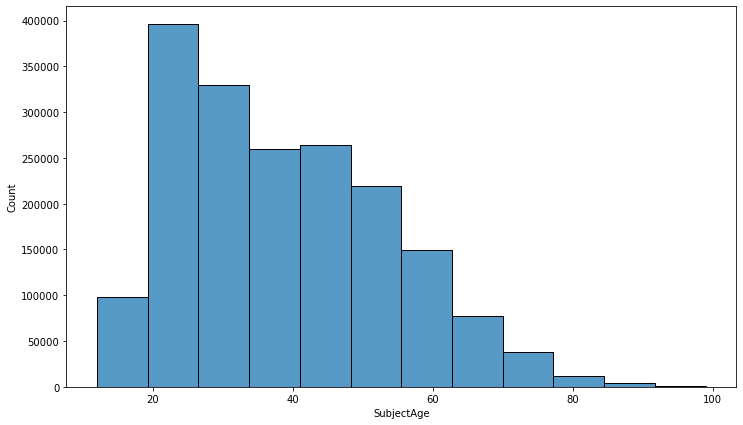

In [494]:
plt.figure(figsize=(12,7))
sns.histplot(df_train['SubjectAge'], bins=12);

### 6. Modelling

In [495]:
df_train.columns

Index(['VehicleSearchedIndicator', 'ContrabandIndicator', 'Department Name',
       'InterventionLocationName', 'InterventionReasonCode',
       'ReportingOfficerIdentificationID', 'ResidentIndicator',
       'SearchAuthorizationCode', 'StatuteReason', 'SubjectAge',
       'SubjectEthnicityCode', 'SubjectRaceCode', 'SubjectSexCode',
       'TownResidentIndicator', 'HourDay', 'DayWeek', 'Month', 'PeriodDay'],
      dtype='object')

In [496]:
df_train.corr()

,VehicleSearchedIndicator,ContrabandIndicator,ResidentIndicator,SubjectAge,TownResidentIndicator,HourDay,DayWeek,Month
VehicleSearchedIndicator,1.000000,0.537241,0.026874,-0.096858,0.033161,0.007268,0.013000,-0.006883
ContrabandIndicator,0.537241,1.000000,0.014601,-0.071405,0.015419,0.003895,0.008435,-0.005554
ResidentIndicator,0.026874,0.014601,1.000000,-0.003293,0.162896,0.007418,-0.033945,-0.012076
SubjectAge,-0.096858,-0.071405,-0.003293,1.000000,0.022458,-0.002057,-0.037811,0.002492
TownResidentIndicator,0.033161,0.015419,0.162896,0.022458,1.000000,0.019587,-0.016883,-0.014169
HourDay,0.007268,0.003895,0.007418,-0.002057,0.019587,1.000000,-0.004205,0.005013
DayWeek,0.013000,0.008435,-0.033945,-0.037811,-0.016883,-0.004205,1.000000,-0.003635
Month,-0.006883,-0.005554,-0.012076,0.002492,-0.014169,0.005013,-0.003635,1.000000


In [497]:
X_train= df_train[[ #'Department Name',
        'InterventionLocationName', 
        #'InterventionReasonCode',
       # 'ResidentIndicator', 
    'SearchAuthorizationCode',
    #'StatuteReason',
    'SubjectAge',
      # 'TownResidentIndicator', 
    'HourDay', 
    #'DayWeek',
    'Month'
    #, 'PartDay'
        ]]

y_train = df_train['ContrabandIndicator']

In [500]:
def preprocess_data(data):
    
    data_ = data.copy()
    
    data_ = drop_duplicates(data_)
    data_ = drop_nulls(data_)
    data_ = preprocess_interventionlocation(data_)
    data_ = preprocess_datetime (data_)
    data_ = preprocess_age(data_)
    
    X = data_[[ 'InterventionLocationName', 'SearchAuthorizationCode', 'SubjectAge', 'HourDay',  'Month']]

    y = data_['ContrabandIndicator']
    
    return X, y
    

In [502]:
X_test, y_test = preprocess_data(df_test)

In [278]:
y_train.value_counts()/y_train.shape[0]

False    0.988753
True     0.011247
Name: ContrabandIndicator, dtype: float64

In [506]:
be = BinaryEncoder()
be.fit(X_train)
X_train_encoded = be.transform(X_train)
X_test_encoded = be.transform(X_test)

C:\Users\ines.s.almeida\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [507]:
def select_k_best(method, X, y, k=4):
    skb = SelectKBest(method, k=k)
    skb.fit(X, y)
    if method is not mutual_info_classif:
        p_values = skb.pvalues_.round(4)
    else:
        p_values = None
    result = pd.DataFrame({
        'column': X.columns, 
        'scores': skb.scores_,
        'selected': skb.get_support()
    }).sort_values(by='scores', ascending=False)
    return result

In [508]:
select_k_best(f_classif, X_train_encoded, y_train,5)

C:\Users\ines.s.almeida\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\ines.s.almeida\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,column,scores,selected
13,SearchAuthorizationCode_1,588070.390621,True
14,SearchAuthorizationCode_2,110181.700663,True
12,SearchAuthorizationCode_0,11918.323775,True
15,SubjectAge,9157.504517,True
7,InterventionLocationName_7,846.543997,True
8,InterventionLocationName_8,461.829419,False
4,InterventionLocationName_4,330.815113,False
9,InterventionLocationName_9,130.907295,False
10,InterventionLocationName_10,58.244423,False
17,Month,49.668965,False


In [509]:
select_k_best(chi2, X_train_encoded, y_train, 5)

,column,scores,selected
13,SearchAuthorizationCode_1,430947.341151,True
15,SubjectAge,52658.774155,True
12,SearchAuthorizationCode_0,11765.024932,True
14,SearchAuthorizationCode_2,1824.583502,True
7,InterventionLocationName_7,457.936376,True
4,InterventionLocationName_4,303.789571,False
8,InterventionLocationName_8,264.288053,False
16,HourDay,120.948174,False
17,Month,100.297018,False
9,InterventionLocationName_9,61.478128,False


In [510]:
X_train_encoded

,InterventionLocationName_0,InterventionLocationName_1,InterventionLocationName_2,InterventionLocationName_3,InterventionLocationName_4,InterventionLocationName_5,InterventionLocationName_6,InterventionLocationName_7,InterventionLocationName_8,InterventionLocationName_9,InterventionLocationName_10,InterventionLocationName_11,SearchAuthorizationCode_0,SearchAuthorizationCode_1,SearchAuthorizationCode_2,SubjectAge,HourDay,Month
1983811,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,36.0,23.2,10
1752272,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,48.0,3.4,5
478740,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,60.0,16.7,7
388494,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,52.0,6.8,6
1086256,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,31.0,18.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73686,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,47.0,21.3,11
840840,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,43.0,1.9,3
493897,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,46.0,23.3,8
494390,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,57.0,8.2,8


## Logistic Regression

In [511]:
lr = LogisticRegression()

lr.fit(X_train_encoded, y_train)

proba = lr.predict_proba(X_test_encoded)
y_pred =  (proba[:,1] >= 0.50)

print('Precision score:', precision_score(y_test,y_pred))
print('Recall score:', recall_score(y_test,y_pred))
print('Accuracy score:', accuracy_score(y_test,y_pred))


C:\Users\ines.s.almeida\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision score: 0.6130434782608696
Recall score: 0.15301139446554532
Accuracy score: 0.9892702450341205


In [ ]:
Precision score: 0.6097959183673469
Recall score: 0.1427206725257929
Accuracy score: 0.9890558493344237


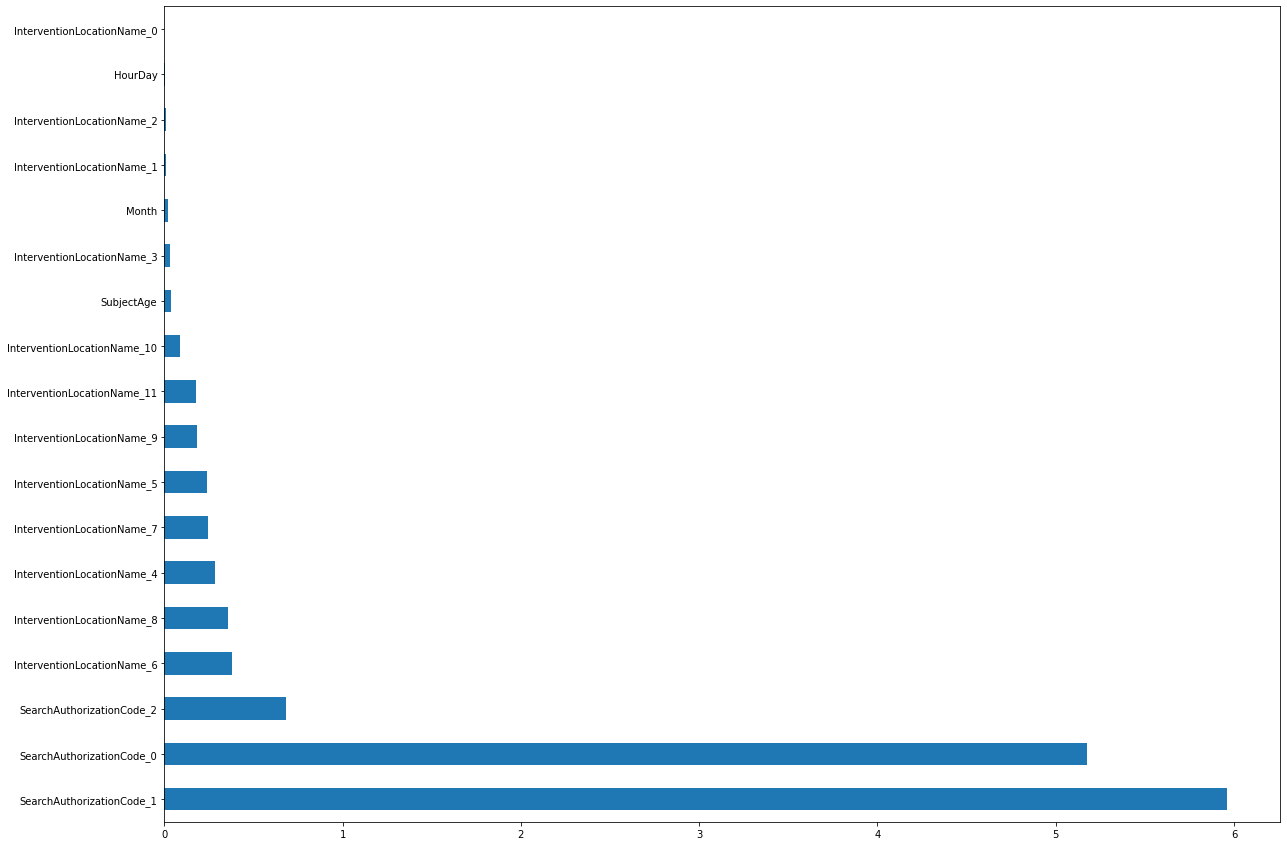

In [512]:
plt.figure(figsize=(20,15))

pd.Series(abs(lr.coef_[0, :]), index=X_train_encoded.columns).nlargest(100).plot.barh();

## Random Forest Classifier

In [513]:
rf = RandomForestClassifier()

rf.fit(X_train_encoded, y_train)

RandomForestClassifier()

In [516]:
rf.predict(X_test_encoded)

array([False, False, False, ..., False, False, False])

In [517]:
print('Precision score:', precision_score(y_test,y_pred))
print('Recall score:', recall_score(y_test,y_pred))
print('Accuracy score:', accuracy_score(y_test,y_pred))

Precision score: 0.9291947639825466
Recall score: 0.847350334599385
Accuracy score: 0.9975299145650717


In [514]:
proba = rf.predict_proba(X_test_encoded)
y_pred =  (proba[:,1] >= 0.50)

print('Precision score:', precision_score(y_test,y_pred))
print('Recall score:', recall_score(y_test,y_pred))
print('Accuracy score:', accuracy_score(y_test,y_pred))

Precision score: 0.9291947639825466
Recall score: 0.847350334599385
Accuracy score: 0.9975299145650717


In [ ]:
Precision score: 0.5822646657571623
Recall score: 0.407718761941154
Accuracy score: 0.9897920721586538

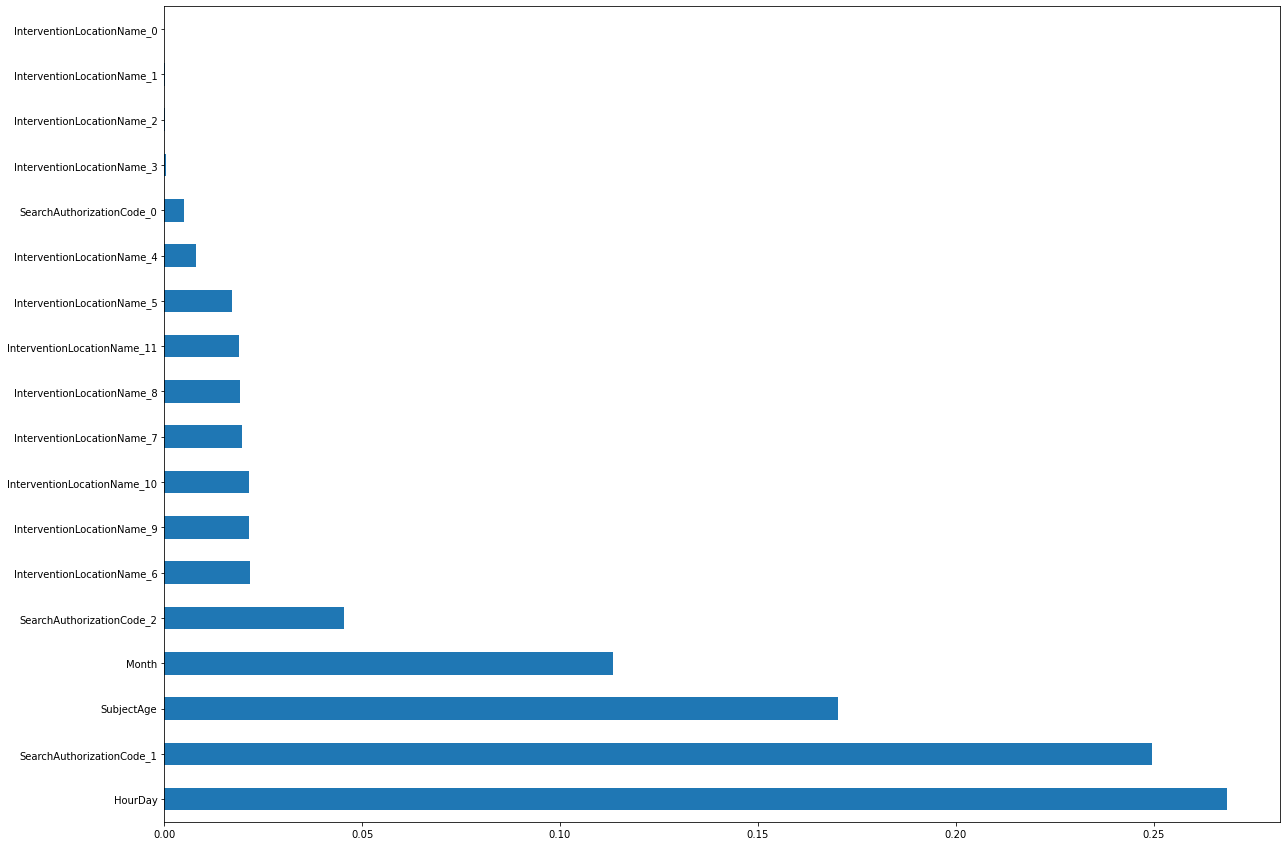

In [518]:
plt.figure(figsize=(20,15))
pd.Series(rf.feature_importances_, index=X_train_encoded.columns).nlargest(X_train_encoded.shape[0]).plot.barh();

In [519]:
def select_from_model(clf, X_train, max_features=5):
    sfm = SelectFromModel(clf, prefit=True, max_features=max_features)
    selected_features = X_train.columns[sfm.get_support()]
    return list(selected_features)

In [520]:
select_from_model(lr,X_train_encoded,10)

['SearchAuthorizationCode_0', 'SearchAuthorizationCode_1']

In [521]:
select_from_model(rf,X_train_encoded,10)

['SearchAuthorizationCode_1', 'SubjectAge', 'HourDay', 'Month']

In [522]:
search_parameters = {
                   "max_depth": [10, 20, 50, 100],
                   "n_estimators": [10, 20, 50, 100]}

In [523]:
randomized_search = RandomizedSearchCV(
                        rf, 
                        search_parameters,
                        cv=3,
                        random_state=1,
                        return_train_score=True,
                        scoring = 'precision'
                        )

In [532]:
rf.__version__

AttributeError: 'RandomForestClassifier' object has no attribute '__version__'

In [535]:
import sklearn.ensemble

In [537]:
sklearn.__version__

'0.23.2'

In [524]:
%%time

randomized_search.fit(X_train_encoded, y_train)

Wall time: 1h 18min 19s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 20, 50, 100],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=1, return_train_score=True,
                   scoring='precision')

In [525]:
randomized_search.best_params_

{'n_estimators': 100, 'max_depth': 10}

In [526]:
pred = randomized_search.predict_proba(X_test_encoded)

In [613]:
threshold = 0.45

In [614]:
y_pred = (pred[:,1] >= threshold)

print('Precision score:', round(precision_score(y_test,y_pred),2))
print('Accuracy score:', round(accuracy_score(y_test,y_pred),2))
print('Recall score:', round(recall_score(y_test,y_pred),2))

Precision score: 0.66
Accuracy score: 0.99
Recall score: 0.35


### Assessing fairness of model for protected classes by assessing precision for each one

In [615]:
def preprocess_data_fairness(data, predictions):
    
    data_ = data.copy()
    
    data_ = drop_duplicates(data_)
    data_ = drop_nulls(data_)
    
    
    data_final = data_[[ 'SubjectEthnicityCode', 'SubjectRaceCode', 'SubjectSexCode']]
    data_final['y'] = data_['ContrabandIndicator']
    data_final['y_pred'] = predictions
    
    return data_final

In [616]:
df_fairness = preprocess_data_fairness(df_test, y_pred)

<ipython-input-615-917409842e43>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['y'] = data_['ContrabandIndicator']
<ipython-input-615-917409842e43>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['y_pred'] = predictions


In [617]:
df_fairness.shape

(486218, 5)

In [618]:
def plot_precision(df , protected_class):
    
    TP = df[(df.y_pred == 1) & (df.y == 1)]
    FP = df[(df.y_pred == 1) & (df.y == 0)]

    prec = TP.groupby(TP[protected_class])[protected_class].count()/(FP.groupby(FP[protected_class])[protected_class].count() + TP.groupby(TP[protected_class])[protected_class].count())
    plt.figure(figsize=(15, 5))
    pal = sns.color_palette("Reds_d", len(prec))

    sns.barplot(prec.index, prec.values)


    ax = sns.barplot(prec.index, prec.values, palette=np.array(pal[::-1]))

    ax.set(xlabel=protected_class, ylabel='Precision')
    plt.show()
    
    print(threshold)
    print(prec)

C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


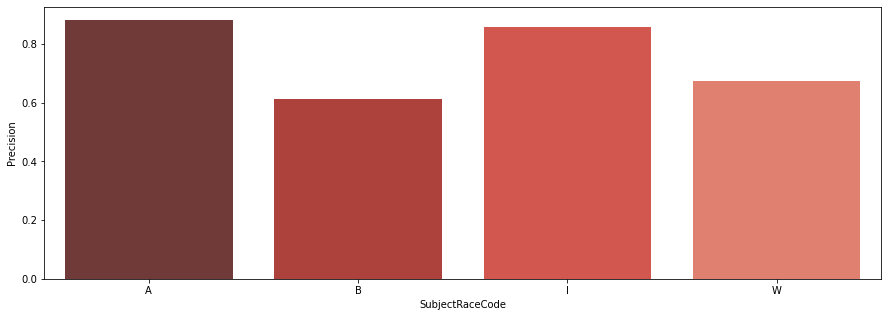

0.45
SubjectRaceCode
A    0.882353
B    0.611183
I    0.857143
W    0.673582
Name: SubjectRaceCode, dtype: float64


In [619]:
plot_precision(df_fairness, 'SubjectRaceCode')

In [620]:
df_fairness['SubjectRaceCode'].value_counts()/df_fairness.shape[0]*100 

W    81.692780
B    15.565446
A     1.948303
I     0.793471
Name: SubjectRaceCode, dtype: float64

C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


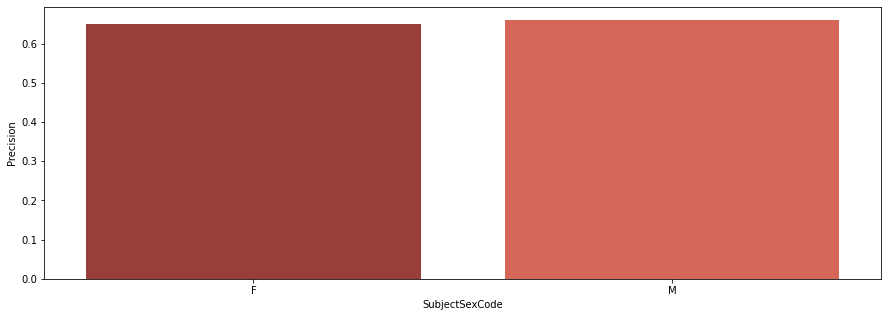

0.45
SubjectSexCode
F    0.650909
M    0.660862
Name: SubjectSexCode, dtype: float64


In [621]:
plot_precision(df_fairness, 'SubjectSexCode')

C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


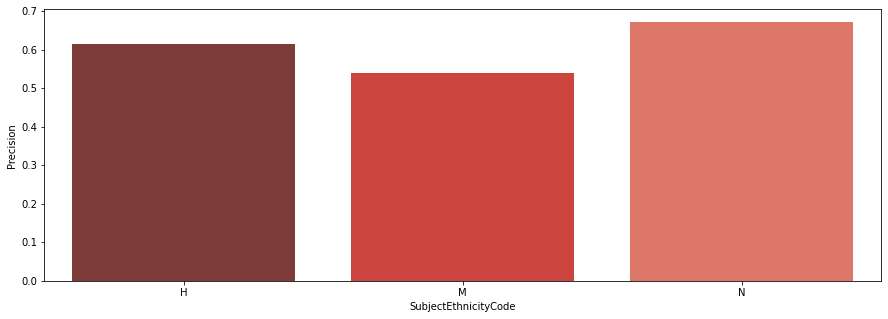

0.45
SubjectEthnicityCode
H    0.614334
M    0.538462
N    0.671489
Name: SubjectEthnicityCode, dtype: float64


In [622]:
plot_precision(df_fairness, 'SubjectEthnicityCode')

In [ ]:
class PreProcess(BaseEstimator, TransformerMixin):
    def fit(self, *_):
        return self
    
    def transform(self, df, *_):
                
        #Drop features
        df = df.rename(columns={"Department Name": "DepartmentName"})
        df = df[['DepartmentName','InterventionReasonCode', 'ResidentIndicator', 'InterventionDateTime',
                   'SearchAuthorizationCode', 'StatuteReason', 'TownResidentIndicator']]

        #InterventionReasonCode
        _df.InterventionReasonCode = _df.InterventionReasonCode.str.lower().str.strip()    
           
        #SearchAuthorizationCode
        _df.SearchAuthorizationCode = _df.SearchAuthorizationCode.str.lower().str.strip()
        
        #DepartmentName  
        _df = _df.rename(columns={"Department Name": "DepartmentName"})
        _df.DepartmentName = _df.DepartmentName.str.lower().str.strip()
        
        #StatuteReason
        _df.StatuteReason = _df.StatuteReason.str.lower().str.strip()
        
        #Conversion to DateTime type
        _df.InterventionDateTime = pd.to_datetime(_df.InterventionDateTime, format='%m/%d/%Y %I:%M:%S %p')
    
        #Creating time features
        _df = _df.assign(HourDay = _df.InterventionDateTime.dt.hour
                         + _df.InterventionDateTime.dt.minute / 60,
                         DayWeek = _df.InterventionDateTime.dt.dayofweek,
                         Month = _df.InterventionDateTime.dt.month
                        )
        #Drop inital DateTime column
        _df = _df.drop(columns='InterventionDateTime')
        
        return _df